In [5]:
from utils.cluster import group_kmeans
from utils.visualize import plot_distortions

import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering with data from day i and day i-1

## Read and preprocess data

In [12]:
# read data
READ_PATH = "data/spy_max_221118.csv"
df = pd.read_csv(READ_PATH)

# rename columns
rename_dict = {"Date": "date", "Open": "open", "High": "high",
               "Low": "low", "Close": "close", "Volume": "volume"}
df.rename(columns=rename_dict, inplace=True)

# compute next day (i+1) return
# we assume a strategy of buying at open and selling at close
df['open_i+1'] = df['open'].shift(-1)
df['close_i+1'] = df['close'].shift(-1)
df.dropna(inplace=True)
annualized_fctr = 252
df['return_i+1'] = (df['close_i+1']-df['open_i+1'])/df['open_i+1']*annualized_fctr

# add clustering attributes 
# open, high, low, close, volume from the day before
df['open_i-1'] = df['open'].shift(1)
df['high_i-1'] = df['high'].shift(1)
df['low_i-1'] = df['low'].shift(1)
df['close_i-1'] = df['close'].shift(1)
df['volume_i-1'] = df['volume'].shift(1)
df.dropna(inplace=True)
# ratio between today and yesterday
df['open/open_i-1'] = df['open']/df['open_i-1']
df['high/high_i-1'] = df['high']/df['high_i-1']
df['low/low_i-1'] = df['low']/df['low_i-1']
df['close/close_i-1'] = df['close']/df['close_i-1']
df['volume/volume_i-1'] = df['volume']/df['volume_i-1']


# save clustering attributes to a new df
use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
            'volume/volume_i-1']
X = df[use_cols]
X.head()

,open/open_i-1,high/high_i-1,low/low_i-1,close/close_i-1,volume/volume_i-1
1,1.000000,1.006396,1.005000,1.007112,0.478967
2,1.005686,1.002825,1.003554,1.002119,0.418939
3,1.004240,1.010563,1.005665,1.010570,2.629906
4,1.012667,1.005575,1.002113,1.004184,1.003967
5,1.000000,0.999307,1.005622,0.999306,0.925870


## Perform clustering

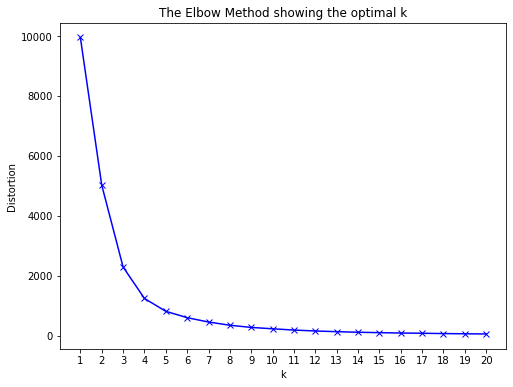

In [6]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X)

# k=4 is the optimal k with elbow method
plot_distortions(k_upper, distortions)

In [10]:
a = pd.DataFrame([1,2,3])
a.shift(-1)

,0
0,2.0
1,3.0
2,NaN


In [ ]:
len(distortions)